In [1]:
%env CUDA_VISIBLE_DEVICES ""

env: CUDA_VISIBLE_DEVICES=""


In [2]:
from mp_20_utils import load_all_data
dataset = "mp_20_biternary"
datasets_pd, torch_datasets, site_to_ids, element_to_ids, spacegroup_to_ids, max_len, max_enumeration, enumeration_stop, enumeration_pad = load_all_data(
    dataset=dataset)

In [4]:
from cascade_transformer.model import CascadeTransformer
from wyckoff_transformer import WyckoffTrainer
from tokenization import PAD_TOKEN, MASK_TOKEN
n_space_groups = len(spacegroup_to_ids)
# Not all 230 space groups are present in the data
# Embedding doesn't support uint8. Sad!
import torch
dtype = torch.int64
device = 'cpu'
cascade_order = ("elements", "symmetry_sites", "symmetry_sites_enumeration")
# (N_i, d_i, pad_i)
assert max_enumeration + 1 == enumeration_stop
assert max_enumeration + 2 == enumeration_pad
enumeration_mask = max_enumeration + 3
assert enumeration_mask < torch.iinfo(dtype).max

cascade = (
    (len(element_to_ids), 128, torch.tensor(element_to_ids[PAD_TOKEN], dtype=dtype, device=device)),
    (len(site_to_ids), 128 - 1, torch.tensor(site_to_ids[PAD_TOKEN], dtype=dtype, device=device)),
    (enumeration_mask + 1, None, torch.tensor(enumeration_pad, dtype=dtype, device=device))
)
model = CascadeTransformer(
    n_start=n_space_groups,
    cascade=cascade,
    n_head=16,
    d_hid=512,
    n_layers=8,
    dropout=0.1,
    use_mixer=True).to(device)
model.load_state_dict(torch.load('checkpoints/2024-05-27_23-47-51/best_model_params.pt', map_location=device))
model.eval()

CascadeTransformer(
  (embedding): CascadeEmbedding(
    (embeddings): ModuleList(
      (0): Embedding(90, 128, padding_idx=88)
      (1): Embedding(78, 127, padding_idx=50)
      (2): None
    )
  )
  (encoder_layers): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLin

In [5]:
idx_to_element = {idx: element for element, idx in element_to_ids.items()}
idx_to_site = {idx: site for site, idx in site_to_ids.items()}
idx_to_spacegroup = {idx: spacegroup for spacegroup, idx in spacegroup_to_ids.items()}
import pickle
with open("wychoffs_enumerated_by_ss.pkl.gz", "rb") as f:
    _, letter_from_ss_enum, _ = pickle.load(f)
from tokenization import PAD_TOKEN, MASK_TOKEN, STOP_TOKEN
SITE_PAD_ID = site_to_ids[PAD_TOKEN]
ELEMENT_PAD_ID = element_to_ids[PAD_TOKEN]
ELEMENT_STOP_ID = element_to_ids[STOP_TOKEN]

In [6]:
from collections import defaultdict
from pyxtal.symmetry import Group
wp_index = defaultdict(lambda: defaultdict(dict))
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()
        wp_index[group_number][wp.site_symm][wp.letter] = (wp.multiplicity, wp.get_dof())

In [7]:
import logging
from copy import deepcopy
# logging.basicConfig(level=logging.INFO)
def tensors_to_pyxtal(tensor, space_group, enforced_min_elements=None, enforced_max_elements=None):
    space_group_real = int(idx_to_spacegroup[int(space_group)])
    pyxtal_args = defaultdict(lambda: [0, []])
    available_sites = deepcopy(wp_index[space_group_real])
    for element_tensor, ss_tensor, enum_tensor in tensor:
        if element_tensor == ELEMENT_STOP_ID:
            break
        if element_tensor == ELEMENT_PAD_ID:
            logging.info("PAD element")
            return None
        element = idx_to_element[element_tensor.item()]
        if ss_tensor == SITE_PAD_ID:
            logging.info("PAD site")
            return None
        ss = idx_to_site[ss_tensor.item()]
        try:
            wp_letter = letter_from_ss_enum[space_group_real][ss][enum_tensor.item()]
        except KeyError:
            logging.info("Invalid WP letter: %i, %s, %i", space_group_real, ss, enum_tensor.item())
            return None
        try:
            our_site = available_sites[ss][wp_letter]
        except KeyError:
            logging.info("Repeated special WP: %i, %s, %s", space_group_real, ss, wp_letter)
            return None
        pyxtal_args[element][0] += our_site[0]
        pyxtal_args[element][1].append(str(our_site[0])+wp_letter)
        if our_site[1] == 0: # The position is special
            del available_sites[ss][wp_letter]
    if enforced_min_elements is not None and len(pyxtal_args.keys()) < enforced_min_elements:
        logging.info("Not enough elements")
        return None
    if enforced_max_elements is not None and len(pyxtal_args.keys()) > enforced_max_elements:
        logging.info("Too many elements")
        return None
    if len(pyxtal_args) == 0:
        logging.info("No structure generated, STOP is the first token")
        return None
    return {
            "spacegroup": space_group_real,
            "sites": [x[1] for x in pyxtal_args.values()],
            "elements": list(map(str, pyxtal_args.keys())),
            "composition": [x[0] for x in pyxtal_args.values()]
        }

In [8]:
from wyckoff_transformer import WyckoffGenerator
mask_dict = {
    "elements": element_to_ids[MASK_TOKEN],
    "symmetry_sites": site_to_ids[MASK_TOKEN],
    "symmetry_sites_enumeration": enumeration_mask
}
generator = WyckoffGenerator(
    model,
    cascade_order,
    mask_dict,
    max_len,
    device="cpu")

In [9]:
valid_generated = []
if dataset == "mp_20_biternary":
    enforced_min_elements = 2
    enforced_max_elements = 3
else:
    enforced_min_elements = None
    enforced_max_elements = None

space_groups = torch_datasets['test']['spacegroup_number'].type(dtype).to(device)
is_valid = torch.zeros(len(space_groups), dtype=bool, device=device, requires_grad=False)
valid_generated = [None] * len(space_groups)

while not is_valid.all():
    generated_tensors = generator.generate_tensors(space_groups[~is_valid])
    indices = torch.nonzero(~is_valid).squeeze(1)
    for i, tensor, space_group in zip(indices, generated_tensors, space_groups[~is_valid]):
        generated = tensors_to_pyxtal(tensor, space_group,
            enforced_max_elements=enforced_max_elements, enforced_min_elements=enforced_min_elements)
        if generated is not None:
            valid_generated[i] = generated
            is_valid[i] = True
    print(is_valid.sum().item(), len(space_groups), is_valid.sum().item() / len(space_groups))
    print(torch.unique(space_groups[~is_valid]))

5111 7118 0.71803877493678
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  17,  19,  20,  23,  24,  25,  27,  29,  30,  33,  34,  35,  36,
         37,  39,  40,  41,  42,  43,  45,  46,  49,  50,  51,  52,  53,  54,
         56,  57,  58,  59,  60,  62,  63,  64,  65,  66,  67,  69,  70,  71,
         72,  74,  75,  76,  77,  79,  81,  83,  84,  86,  87,  88,  91,  92,
         93,  94,  95,  96,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 112, 113, 114, 116, 118, 119, 120, 121, 123, 124, 125,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171])
6427 7118 0.9029221691486372
tensor([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
         17,  20,  24,  25,  27,  29,  33,  34,  35,  39,  41,  42,  43,  45,
         46,

In [10]:
from collections import Counter
train_counts_1 = Counter(datasets_pd['train']['spacegroup_number'])

In [11]:
train_counts_2 = Counter(datasets_pd['train']['spacegroup.number'])

In [17]:
test_counts = Counter(space_groups.tolist())

In [18]:
for c in [70, 62,  85, 125, 138]:
    print(train_counts_1[c], train_counts_2[c], test_counts[c])

66 66 5
1157 1156 2
5 5 2
16 16 2
3 3 2


In [19]:
valid_generated = [x for x in valid_generated if x is not None]

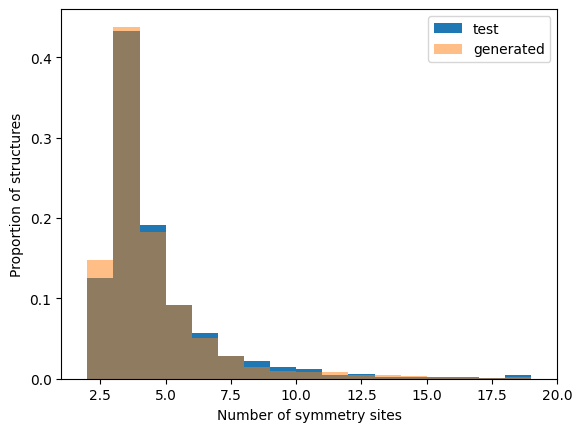

In [23]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(1, max_len)
ax.hist(datasets_pd['test'].symmetry_sites.map(len), label="test", density=True, bins=x)
#ax.hist(datasets_pd['train'].symmetry_sites.map(len), label="train", density=True, alpha=0.5, bins=x)
ax.hist(list(map(lambda s: sum(map(len, s['sites'])), valid_generated)), label="generated", density=True, alpha=0.5, bins=x)
ax.set_xlabel("Number of symmetry sites")
ax.set_ylabel("Proportion of structures")
ax.legend()
ax.set_xlim(1, max_len);

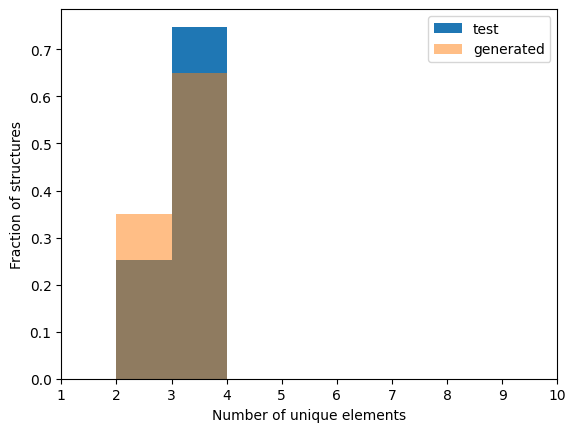

In [24]:
def count_elements(record):
    return len(set(record["elements"]))
def count_elements_pd(record):
    return len(set(record.structure.elements))
fig, ax = plt.subplots()
bins = np.arange(1, 10)
ax.hist(datasets_pd['test'].apply(count_elements_pd, axis=1), label="test", density=True, bins=bins)
#ax.hist(datasets_pd['train'].apply(count_elements_pd, axis=1), label="train", density=True, alpha=0.5, bins=bins)
ax.hist(list(map(count_elements, valid_generated)), label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Fraction of structures")
ax.legend()
ax.set_xlim((1,10));

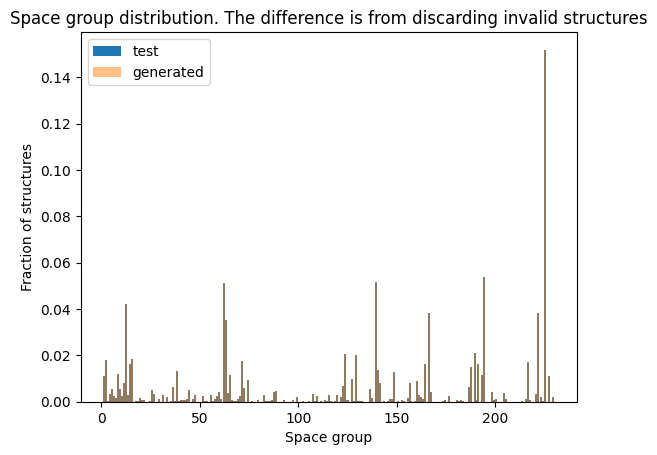

In [25]:
fig, ax = plt.subplots()
bins = np.arange(1, 231)
ax.hist(datasets_pd['test']['spacegroup_number'], label="test", density=True, bins=bins)
ax.hist(list(map(lambda x: x['spacegroup'], valid_generated)), label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Space group")
ax.set_ylabel("Fraction of structures")
ax.set_title("Space group distribution. The difference is from discarding invalid structures")
ax.legend();

In [26]:
import pyxtal
example = valid_generated[2]
generator = pyxtal.pyxtal()
generator.from_random(3, group=example["spacegroup"], species=example["elements"],
                      numIons=example["composition"], sites=example["sites"])

In [27]:
example

{'spacegroup': 8,
 'sites': [['2a', '2a', '2a', '2a', '2a'], ['2a', '2a']],
 'elements': ['Mg', 'Cd'],
 'composition': [10, 4]}

In [28]:
ase_struct = generator.to_ase()
import ase.visualize
ase.visualize.view(ase_struct, viewer="ngl")

In [29]:
import json
with open(f"generated_{dataset}.json", "w") as f:
    json.dump(valid_generated, f)